In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

In [2]:
data = pd.read_csv('/content/Advertising_125obs.csv')

data.sample(10)

,Unnamed: 0,TV,radio,newspaper,sales
64,65,131.1,42.8,28.9,18.0
63,64,102.7,29.6,8.4,14.0
88,89,88.3,25.5,73.4,12.9
79,80,116.0,7.7,23.1,11.0
66,67,31.5,24.6,2.2,9.5
74,75,213.4,24.6,13.1,17.0
15,16,195.4,47.7,52.9,22.4
54,55,262.7,28.8,15.9,20.2
30,31,292.9,28.3,43.2,21.4
21,22,237.4,5.1,23.5,12.5


In [3]:
data = data.drop(['Unnamed: 0'], axis=1)
print(data.isnull().sum())

TV           0
radio        0
newspaper    0
sales        0
dtype: int64


### ANALYSIS - UNIVARIATE & BIVARIATE

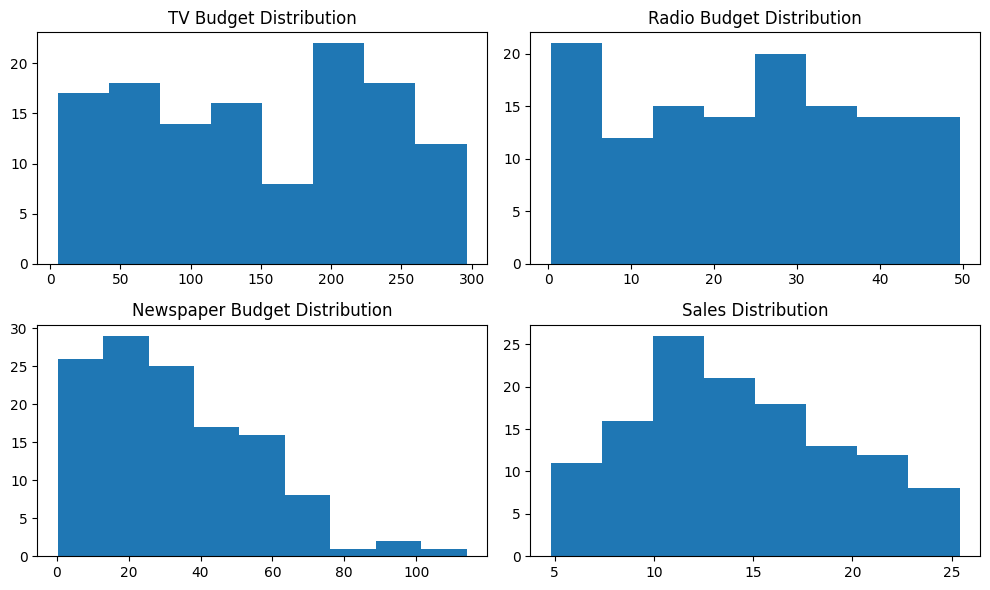

In [4]:
plt.figure(figsize=(10, 6))

plt.subplot(2, 2, 1)
plt.hist(data["TV"], bins="auto")
plt.title("TV Budget Distribution")

plt.subplot(2, 2, 2)
plt.hist(data["radio"], bins="auto")
plt.title("Radio Budget Distribution")

plt.subplot(2, 2, 3)
plt.hist(data["newspaper"], bins="auto")
plt.title("Newspaper Budget Distribution")

plt.subplot(2, 2, 4)
plt.hist(data["sales"], bins="auto")
plt.title("Sales Distribution")

plt.tight_layout()

plt.show()

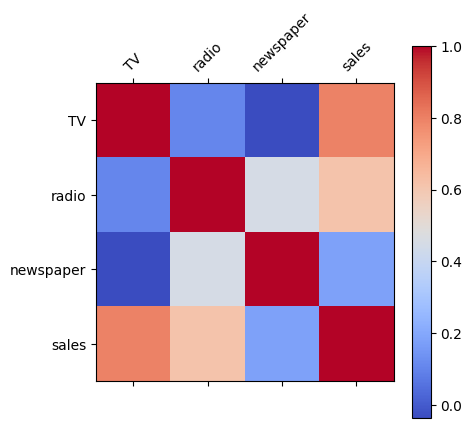

In [5]:
correlation_matrix = data.corr()
plt.matshow(correlation_matrix, cmap='coolwarm')
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.colorbar()
plt.show()

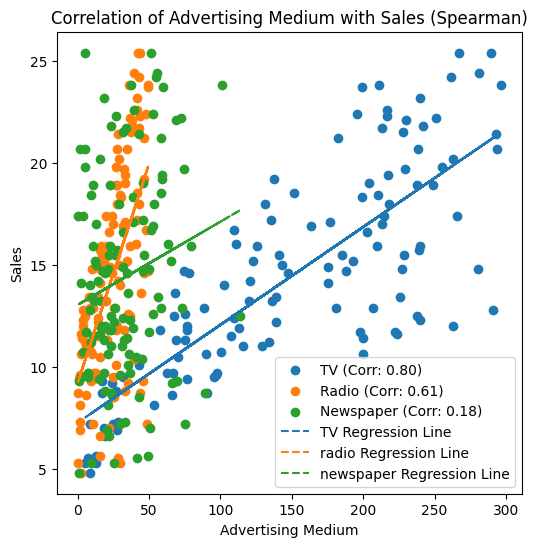

In [6]:
correlation = data.corr(method='spearman')
fig, ax = plt.subplots(figsize=(6, 6))

models = {}
for col in ['TV', 'radio', 'newspaper']:
  model = LinearRegression()
  model.fit(data[[col]], data['sales'])
  models[col] = model

ax.scatter(data['TV'], data['sales'], label=f'TV (Corr: {correlation.loc["TV", "sales"]:.2f})')
ax.scatter(data['radio'], data['sales'], label=f'Radio (Corr: {correlation.loc["radio", "sales"]:.2f})')
ax.scatter(data['newspaper'], data['sales'], label=f'Newspaper (Corr: {correlation.loc["newspaper", "sales"]:.2f})')

for col, model in models.items():
  x = data[col]
  y = model.predict(data[[col]])
  ax.plot(x, y, linestyle='--', label=f'{col} Regression Line')

ax.set_xlabel('Advertising Medium')
ax.set_ylabel('Sales')
ax.set_title('Correlation of Advertising Medium with Sales (Spearman)')

ax.legend()

plt.show()

### ANOVA


In [7]:
model = ols('sales ~ TV + radio + newspaper', data=data).fit()

anova_table = anova_lm(model)
print(anova_table)

              df       sum_sq      mean_sq           F        PR(>F)
TV           1.0  2030.332130  2030.332130  909.498296  4.031427e-58
radio        1.0   909.583141   909.583141  407.452704  1.519555e-40
newspaper    1.0     4.416249     4.416249    1.978283  1.621345e-01
Residual   121.0   270.116160     2.232365         NaN           NaN


### HYPOTHESIS TESTING

In [8]:
advertising_budgets = ['TV', 'radio', 'newspaper']
sales_data = data['sales'].tolist()

confidence_level = 0.95

mean_differences = []
ci_lower = []
ci_upper = []

for budget in advertising_budgets:
  budget_data = data[budget].tolist()

  t_statistic, p_value = ttest_ind(budget_data, sales_data)

  mean_difference = np.mean(budget_data) - np.mean(sales_data)
  std_err = np.std(np.concatenate((budget_data, sales_data))) / np.sqrt(len(budget_data) + len(sales_data))
  try:
      from scipy.stats import t
  except ImportError:
      print("Error: scipy.stats library not found. Please install it using 'pip install scipy'.")
      break

  margin_of_error = t.ppf(1 - (1 - confidence_level) / 2, len(budget_data) + len(sales_data) - 2) * std_err

  mean_differences.append(mean_difference)

  ci_lower.append(mean_difference - margin_of_error)
  ci_upper.append(mean_difference + margin_of_error)

  print(f"\nResults for {budget} advertising budget:")
  print("t-statistic:", t_statistic)
  print("p-value:", p_value)
  print(f"Confidence Interval ({confidence_level:.0%} level):", f"({mean_difference:.2f} +/- {margin_of_error:.2f})")

  alpha = 0.05

  if p_value < alpha:
    print("Reject null hypothesis: There is a significant impact of", budget, "advertising budget on sales.")
  else:
    print("Fail to reject null hypothesis: There might be no significant impact of", budget, "advertising budget on sales.")


Results for TV advertising budget:
t-statistic: 17.755034942022203
p-value: 4.516901718185219e-46
Confidence Interval (95% level): (134.15 +/- 11.17)
Reject null hypothesis: There is a significant impact of TV advertising budget on sales.

Results for radio advertising budget:
t-statistic: 7.082235304828358
p-value: 1.4580131704764752e-11
Confidence Interval (95% level): (9.76 +/- 1.48)
Reject null hypothesis: There is a significant impact of radio advertising budget on sales.

Results for newspaper advertising budget:
t-statistic: 9.07301981340663
p-value: 3.673172885758698e-17
Confidence Interval (95% level): (18.76 +/- 2.34)
Reject null hypothesis: There is a significant impact of newspaper advertising budget on sales.


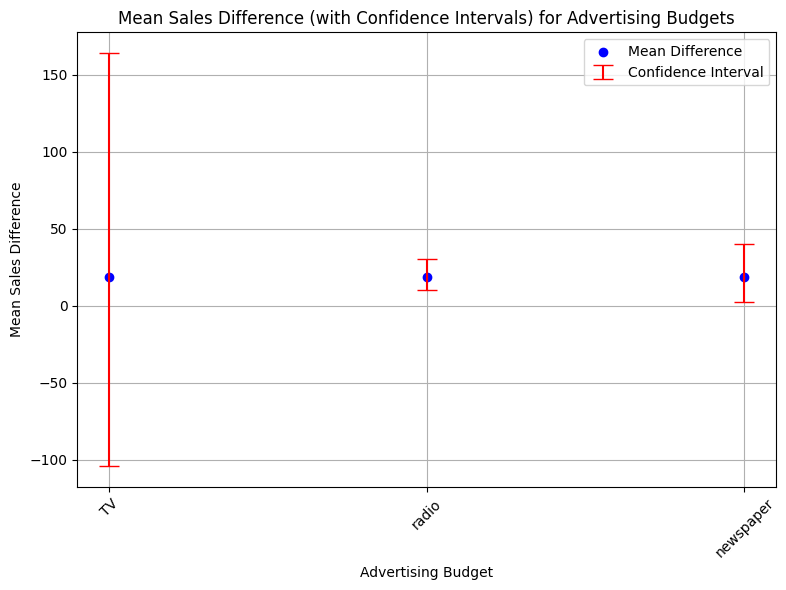

In [9]:
budget_means = [mean_difference for budget in advertising_budgets]

plt.figure(figsize=(8, 6))
plt.scatter(advertising_budgets, budget_means, color='blue', label='Mean Difference')
plt.errorbar(advertising_budgets, budget_means, yerr=[ci_lower, ci_upper], fmt='none', ecolor='red', capsize=7, label='Confidence Interval')
plt.xlabel('Advertising Budget')
plt.ylabel('Mean Sales Difference')
plt.title('Mean Sales Difference (with Confidence Intervals) for Advertising Budgets')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### SCALE DATA

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

data = pd.DataFrame(scaler.fit_transform(data.values), columns=data.columns, index=data.index)
data.sample(10)

,TV,radio,newspaper,sales
91,-1.428056,-1.563065,-0.006269,-1.396475
102,1.567719,-0.969405,-0.522785,0.082508
97,0.432992,-0.216976,-0.496068,0.220546
43,0.694944,-1.086757,-0.300149,-0.292168
30,1.718937,0.286945,0.447908,1.384012
31,-0.424305,-0.465485,0.243083,-0.489366
46,-0.700545,-0.983211,0.113954,-0.745723
103,0.468713,-0.479291,-0.678630,0.062788
33,1.393879,-0.286006,-1.462308,0.595222
58,0.741381,1.757288,0.203008,1.857287


### SIMPLE LINEAR REGRESSION

Simple Linear Regression (Sales vs TV)
Feature: TV
R-squared: 0.7100277855344144
Mean Squared Error: 0.3512020667783605

Simple Linear Regression (Sales vs radio)
Feature: radio
R-squared: 0.41482803584709405
Mean Squared Error: 0.7087355028481322

Simple Linear Regression (Sales vs newspaper)
Feature: newspaper
R-squared: 0.035136974554365596
Mean Squared Error: 1.1686012376014923



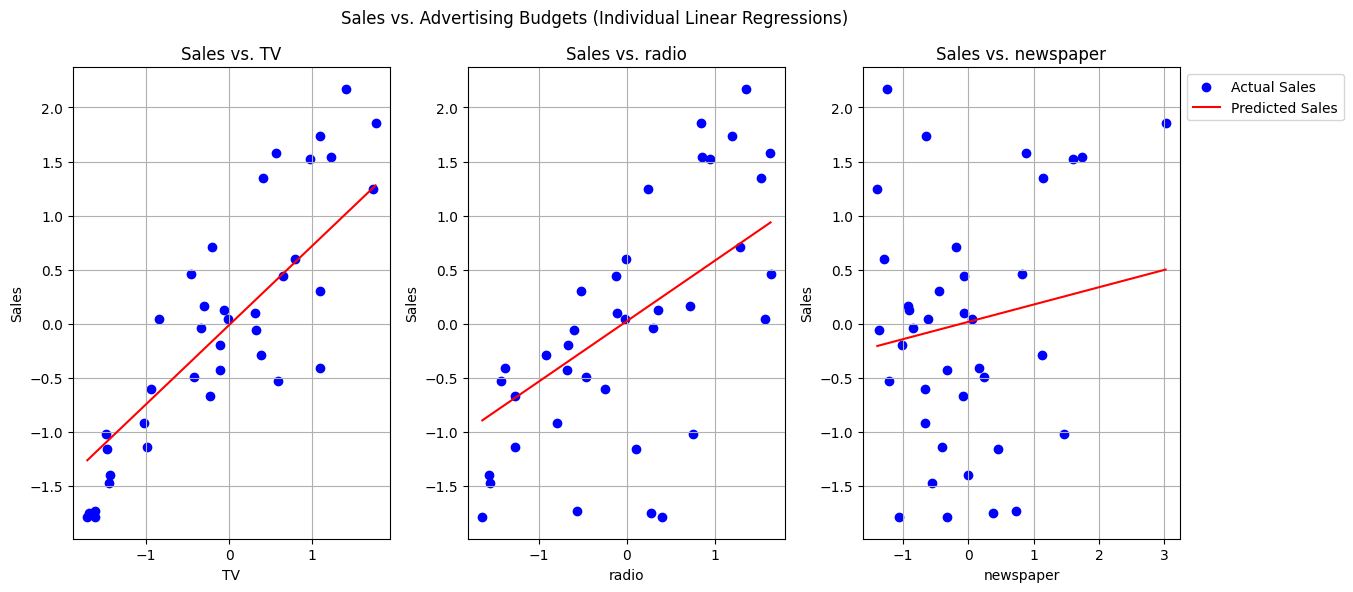

In [11]:
advertising_features = [col for col in data.columns if col != 'sales']

fig, axes = plt.subplots(1, len(advertising_features), figsize=(12, 6))
axes = axes.ravel()

for i, feature in enumerate(advertising_features):
  target = 'sales'

  X = data[[feature]]
  y = data[target]

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

  model = LinearRegression()
  model.fit(X_train, y_train)

  y_pred = model.predict(X_test)

  r2 = model.score(X_test, y_test)
  mse = mean_squared_error(y_test, y_pred)

  axes[i].scatter(X_test, y_test, color='blue', label='Actual Sales')
  m, b = model.coef_[0], model.intercept_
  x_reg = np.linspace(X_test[feature].min(), X_test[feature].max(), 100)
  y_reg = m * x_reg + b
  axes[i].plot(x_reg, y_reg, color='red', linestyle='-', label='Predicted Sales')

  axes[i].set_xlabel(feature)
  axes[i].set_ylabel('Sales')
  axes[i].set_title(f"Sales vs. {feature}")
  axes[i].grid(True)

  print(f"Simple Linear Regression (Sales vs {feature})")
  print(f"Feature: {feature}")
  print(f"R-squared: {r2}")
  print(f"Mean Squared Error: {mse}\n")

plt.suptitle('Sales vs. Advertising Budgets (Individual Linear Regressions)')
plt.tight_layout()
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

### MULTIPLE LINEAR REGRESSION

Multiple Linear Regression (Sales vs radio, newspaper)
Features: radio, newspaper
R-squared: 0.3995888819398081
Mean Squared Error: 0.7271925207319182

Multiple Linear Regression (Sales vs radio, TV)
Features: radio, TV
R-squared: 0.9342384496246534
Mean Squared Error: 0.07964760502634996

Multiple Linear Regression (Sales vs newspaper, TV)
Features: newspaper, TV
R-squared: 0.7318557588275793
Mean Squared Error: 0.324764949869519

Multiple Linear Regression (Sales vs radio, newspaper, TV)
Features: radio, newspaper, TV
R-squared: 0.9295566442562677
Mean Squared Error: 0.08531800942927327



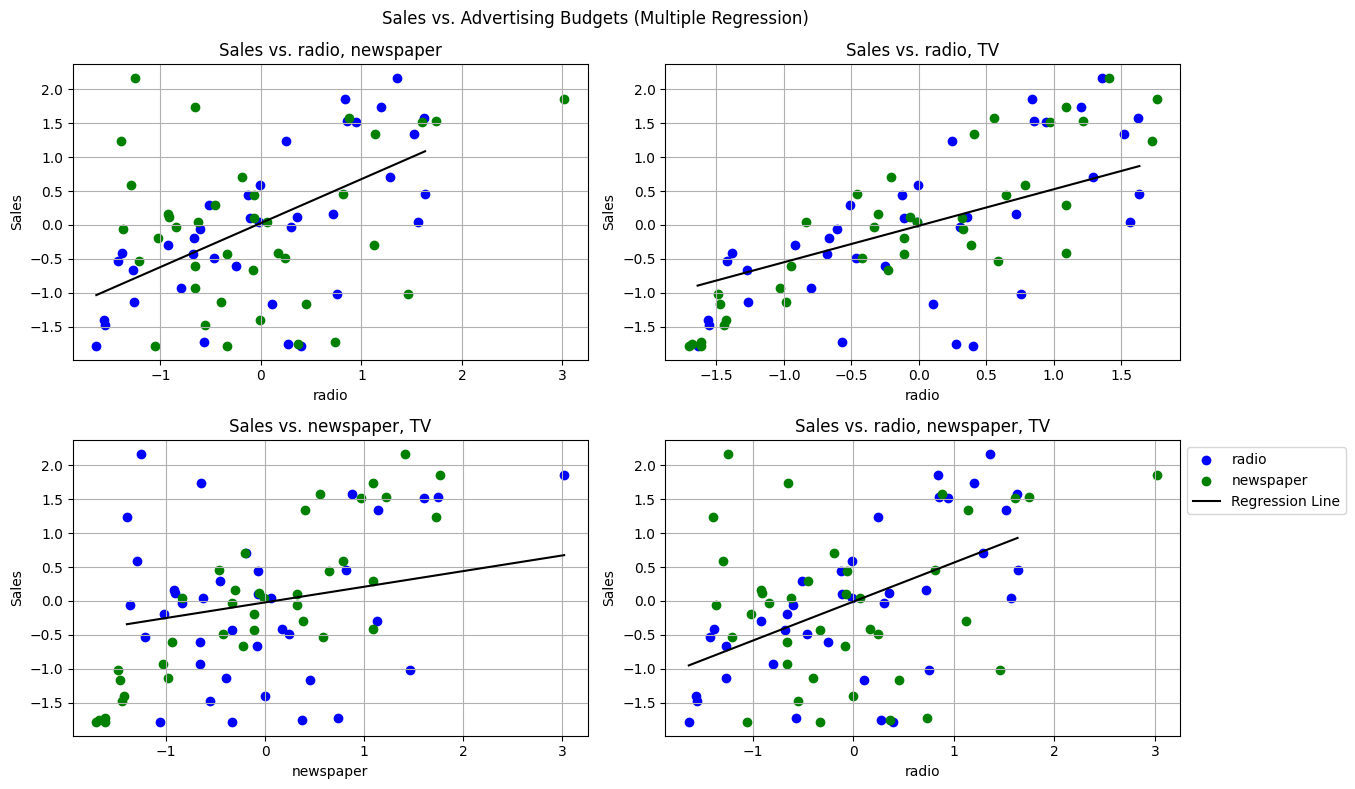

In [12]:
if data.columns[0] == '':
  data = data.iloc[:, 1:]

features = ['radio', 'newspaper', 'TV']
target = 'sales'

combos = [
  ['radio', 'newspaper'],
  ['radio', 'TV'],
  ['newspaper', 'TV'],
  features
]

colors = ['blue', 'green', 'red']

rows = 2
cols = 2

fig, axes = plt.subplots(rows, cols, figsize=(12, 8))

for i, (combo, ax) in enumerate(zip(combos, axes.flat)):
  X = data[combo]
  y = data[target]

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

  model = LinearRegression()
  model.fit(X_train, y_train)

  y_pred = model.predict(X_test)

  r2 = model.score(X_test, y_test)
  mse = mean_squared_error(y_test, y_pred)

  print(f"Multiple Linear Regression (Sales vs {', '.join(combo)})")
  print(f"Features: {', '.join(combo)}")
  print(f"R-squared: {r2}")
  print(f"Mean Squared Error: {mse}\n")

  feature1 = X_test[combo[0]]
  feature2 = X_test[combo[1]]

  ax.scatter(feature1, y_test, color=colors[0], label=combo[0])
  ax.scatter(feature2, y_test, color=colors[1], label=combo[1])

  m, b = model.coef_[0], model.intercept_

  x_min, x_max = X_test[combo[0]].min(), X_test[combo[0]].max()
  x_reg = np.linspace(x_min, x_max, 100)

  y_reg = m * x_reg + b

  ax.plot(x_reg, y_reg, color='black', linestyle='-', label='Regression Line')

  ax.set_xlabel(combo[0])
  ax.set_ylabel('Sales')
  ax.set_title(f"Sales vs. {', '.join(combo)}")
  ax.grid(True)
  fig.suptitle('Sales vs. Advertising Budgets (Multiple Regression)')

plt.tight_layout()
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

### BACKWARD ELIMINATION (MODEL SELECTION) - MULTIPLE REGRESSION

Features: Index(['TV', 'radio', 'newspaper', 'sales'], dtype='object')
             coef  std err       t  P>|t|  [0.025  0.975]
const     -0.0087    0.032  -0.272  0.786  -0.073   0.055
TV         0.7101    0.033  21.700  0.000   0.645   0.775
radio      0.5751    0.037  15.398  0.000   0.501   0.649
newspaper -0.0694    0.038  -1.848  0.068  -0.144   0.005

Selected features using Backward Elimination: ['TV', 'radio']
         coef  std err       t  P>|t|  [0.025  0.975]
const -0.0112    0.033  -0.345  0.731  -0.076   0.053
TV     0.7179    0.033  21.808  0.000   0.652   0.783
radio  0.5392    0.032  16.657  0.000   0.475   0.604



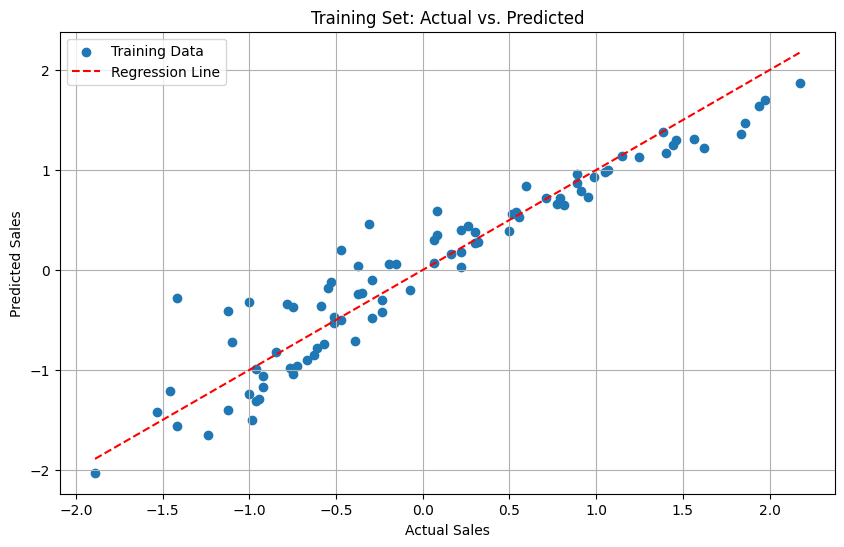

In [13]:
X = data[['TV', 'radio', 'newspaper']]
y = data['sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train_sm = sm.add_constant(X_train)

model = sm.OLS(y_train, X_train_sm).fit()

summary = model.summary()
summary_html = summary.tables[1].as_html()
summary_df = pd.read_html(summary_html, header=0, index_col=0)[0]

print("Features:", data.columns)
print(summary_df)

cols = list(X_train.columns)
pmax = 1
while (len(cols) > 0):
    p = []
    X_1 = X_train[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y_train, X_1).fit()
    p = pd.Series(model.pvalues.values[1:], index=cols)
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if (pmax > 0.05):
        cols.remove(feature_with_p_max)
    else:
        break

selected_features_BE = cols
print()
print("Selected features using Backward Elimination:", selected_features_BE)

X_train_selected = X_train[selected_features_BE]
X_train_selected = sm.add_constant(X_train_selected)
model = sm.OLS(y_train, X_train_selected).fit()

summary = model.summary()
summary_html = summary.tables[1].as_html()
summary_df = pd.read_html(summary_html, header=0, index_col=0)[0]

print(summary_df)
print()

plt.figure(figsize=(10, 6))

plt.scatter(y_train, model.predict(X_train_selected), label='Training Data')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], 'r--', label='Regression Line')
plt.title('Training Set: Actual vs. Predicted')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.legend()
plt.grid(True)

plt.show()